In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import glob

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [3]:
import tensorflow as tf
tf.enable_eager_execution()

In [4]:
from agnfinder.tf_sampling import deep_emulator

In [5]:
os.chdir('/home/mike/repos/agnfinder')
# sotiria, change this to repo loc

In [18]:
galaxy_locs

['results/emulated_sampling/real/galaxy_4_performance.h5',
 'results/emulated_sampling/real/galaxy_16_performance.h5',
 'results/emulated_sampling/real/galaxy_22_performance.h5',
 'results/emulated_sampling/real/galaxy_1_performance.h5',
 'results/emulated_sampling/real/galaxy_31_performance.h5',
 'results/emulated_sampling/real/galaxy_8_performance.h5',
 'results/emulated_sampling/real/galaxy_27_performance.h5',
 'results/emulated_sampling/real/galaxy_11_performance.h5',
 'results/emulated_sampling/real/galaxy_28_performance.h5',
 'results/emulated_sampling/real/galaxy_32_performance.h5',
 'results/emulated_sampling/real/galaxy_15_performance.h5',
 'results/emulated_sampling/real/galaxy_30_performance.h5',
 'results/emulated_sampling/real/galaxy_13_performance.h5',
 'results/emulated_sampling/real/galaxy_24_performance.h5',
 'results/emulated_sampling/real/galaxy_29_performance.h5',
 'results/emulated_sampling/real/galaxy_10_performance.h5',
 'results/emulated_sampling/real/galaxy_18_

In [41]:
len(galaxy_locs), len(labels)

(33, 34)

In [34]:
params = ['mass', 'dust2', 'tage', 'tau', 'agn_disk_scaling', 'agn_eb_v', 'agn_torus_scaling']
save_dir = 'results/emulated_sampling/real'

galaxy_locs = glob.glob(save_dir + '/galaxy*.h5')
assert galaxy_locs

galaxies = []
true_observations = len(galaxy_locs)
for n, galaxy_loc in enumerate(galaxy_locs):
    f = h5py.File(galaxy_loc, mode='r')
    galaxies.append({
        'samples': np.squeeze(f['samples'][...]),
        'name': galaxy_loc.split('_')[-2],
        'true_observations': np.squeeze(f['true_observations'][...]),
    })

n_samples = sample_list[0].shape[0]
# samples = np.stack(sample_list, axis=1)

In [35]:
galaxies[0]['true_observations'].shape

(12,)

### Load parquet for labels

In [26]:
rf_classes = ['passive', 'starforming', 'starburst', 'agn', 'qso', 'outlier']
rf_cols = [f'Pr[{c}]_case_III' for c in rf_classes]
labels = pd.read_parquet('data/uk_ir_selection.parquet')

In [28]:
labels['most_likely_rf_class'] = labels[rf_cols].apply(lambda x: rf_classes[np.argmax(x.values)], axis=1)
labels['most_likely_rf_class'].value_counts()

passive        9
starforming    7
qso            7
starburst      6
agn            5
Name: most_likely_rf_class, dtype: int64

In [30]:
label_dict = dict(zip(labels.index, labels['most_likely_rf_class'].values))
label_dict

{0: 'starforming',
 1: 'starforming',
 2: 'starforming',
 3: 'starforming',
 4: 'starforming',
 5: 'starforming',
 6: 'starforming',
 7: 'starburst',
 8: 'starburst',
 9: 'starburst',
 10: 'starburst',
 11: 'starburst',
 12: 'starburst',
 14: 'qso',
 15: 'qso',
 16: 'qso',
 17: 'qso',
 18: 'qso',
 19: 'qso',
 20: 'qso',
 21: 'passive',
 22: 'passive',
 23: 'passive',
 24: 'passive',
 25: 'passive',
 26: 'passive',
 27: 'passive',
 28: 'passive',
 29: 'passive',
 30: 'agn',
 31: 'agn',
 32: 'agn',
 33: 'agn',
 34: 'agn'}

In [38]:
for galaxy in galaxies:
    galaxy['rf_class'] = label_dict[int(galaxy['name'])]

KeyError: 13

### How do we do at reproducing observations?

In [8]:
checkpoint_loc = 'results/checkpoints/latest'
emulator = deep_emulator.get_trained_keras_emulator(deep_emulator.tf_model(), checkpoint_loc, new=False)

In [15]:
photometry = deep_emulator.denormalise_photometry(emulator(samples[0, :1]).numpy())

In [16]:
photometry.shape

(1, 12)

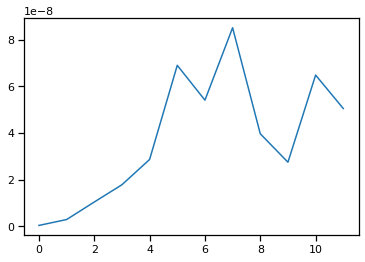

In [17]:
plt.plot(photometry[0])

In [21]:
names

['4',
 '16',
 '22',
 '1',
 '31',
 '8',
 '27',
 '11',
 '28',
 '32',
 '15',
 '30',
 '13',
 '24',
 '29',
 '10',
 '18',
 '7',
 '9',
 '14',
 '12',
 '25',
 '5',
 '20',
 '6',
 '23',
 '3',
 '26',
 '0',
 '17',
 '2',
 '33',
 '19']

In [22]:
int(names[0])

4

In [20]:
data = []
for n, galaxy in enumerate(sample_list):
        temp_df = pd.DataFrame(galaxy, columns=params)
        temp_df['galaxy_class'] = labels.iloc[int(names[n])]['most_likely_rf_class']
        data.append(temp_df)
raw_df = pd.concat(data).reset_index()
del data

KeyError: 'most_likely_rf_class'

In [ ]:
raw_df.head()

In [ ]:
len(raw_df)

In [ ]:
df = raw_df

In [ ]:
# free_params = ['mass', 'dust2', 'tage', 'agn_eb_v', 'agn_torus_mass']
# log_params = ['mass', 'agn_mass', 'tau']

In [ ]:
nrows = len(params)
fig, axes = plt.subplots(nrows=nrows, figsize=(12, 6 * nrows))
for ax_n, ax in enumerate(axes):
    feature = params[ax_n]
    #  _ = sns.catplot(data=df, x='galaxy_class', y=feature, kind="violin", ax=ax)
    for galaxy_class in rf_classes:
        values = df[df['galaxy_class'] == galaxy_class][feature]
#         if feature in log_params:
#             values = np.log10(values)
        sns.distplot(values, label=galaxy_class, ax=ax)
        ax.legend()
#     ax.set_ylim(limits[feature])
# print('done')